In [1]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
# plt.style.use(['seaborn-notebook'])

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
from utils import dmaps

In [4]:
eps = 0.005

# underlying OU process coefficients
def drift_ou(t, u, du):
    du[0] = 1.0
    du[1] = (u[0] - u[1]) / eps

def dispersion_ou(t, u, du):
    du[0,0] = 1.0 / np.sqrt(100)
    du[1,1] = 1.0 / np.sqrt(eps)#np.sqrt(1.0)

sde_ou = spaths.ItoSDE(drift_ou, dispersion_ou, noise_mixing_dim=2)

In [5]:
# A = np.array(
#     [[0.0, 0.0],
#      [1.0, -1.0]]
# )
# # TODO: add linear SDEs to spaths

# B = np.array(
#     [[0.01, 0.0],
#      [0.0,  1.0]]
# )
# sde_ou = spaths.OrnsteinUhlenbeck(A, B)

In [6]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [7]:
# simulation params
dt = .001
x0, y0 = 3.0, 3.0
tspan = (0.0, 15.0)

In [8]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
sol_ou = em.solve(sde_ou, ens0, tspan, dt)

In [9]:
sol_ou.p.shape

(1, 15002, 2)

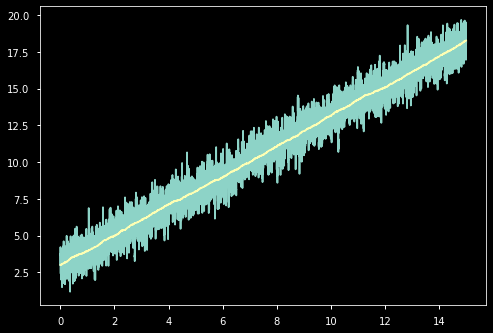

In [10]:
path = sol_ou.p[0]
plt.plot(sol_ou.t, path.T[1])
plt.plot(sol_ou.t, path.T[0]);

In [11]:
data = path[::3]

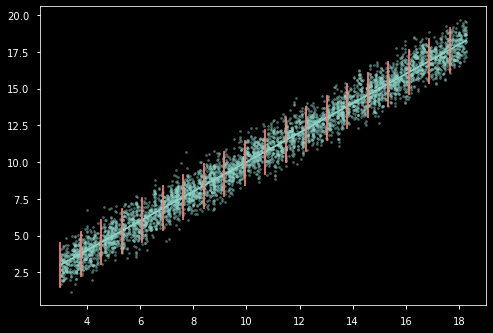

In [12]:
# plt.figure(figsize=(10,7))
plt.scatter(*data.T, s=5, alpha=0.5);
u = np.linspace(min(data.T[0]), max(data.T[0]), 100)
plt.plot(u,u);
for u0 in u[::5]:
    u = 50*[u0]
    v = np.linspace(u0-1.5, u0+1.5, 50)
    plt.plot(u, v, color='C3');

In [13]:
# transformation
f = lambda r: jnp.log(1 + r**2)
# g = lambda r: r**3 / (1 + r**2)
g = lambda r: jnp.sin(.5 * r)
ginv = lambda s: 2 * jnp.arcsin(s)

In [14]:
F = lambda u, v: jnp.array([v, f(v) + g(u-v)])
G = lambda x, y: jnp.array([ginv(y-f(x)) + x, x])
# fwdF = lambda u: np.asarray([u[1], np.log(1+u[1])+np.sin(.5*(u[0] - u[1]))])

In [15]:
np.allclose(G(*F(*data.T)).T, data)

/Users/Przemek/miniconda3/envs/py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


True

In [16]:
Fdata = F(*data.T).T
Fdata = rng.permutation(Fdata)  # results do not depend on time relation

In [17]:
Fdata.shape

(5001, 2)

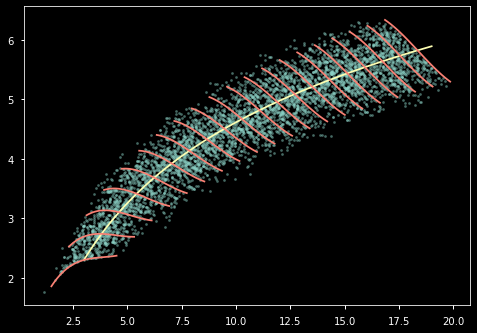

In [18]:
# plt.figure(figsize=(10,7))
plt.scatter(*Fdata.T, alpha=.5, s=5);
u = np.linspace(3, 19, 100)
spine = F(u, u)
plt.plot(*spine, c='C1');

fibers = []
for u0 in u[::5]:
    v = np.linspace(u0-1.5, u0+1.5, 50)
    fibers.append(F(u0, v))
    plt.plot(*F(u0, v), color='C3')

In [20]:
ends = np.array([fib.T[10*(-1)**n] for n, fib in enumerate(fibers)])

In [21]:
fwdF = lambda uv: F(uv[0], uv[1])
bwdF = lambda xy: G(xy[0], xy[1])

FT = spaths.SDETransform(fwdF, bwdF)
sde_Fou = FT(sde_ou)

In [111]:
start = [Fdata[1000]]

tspan = (0, 1)
test_sol = em.solve(sde_Fou, start, tspan, dt)

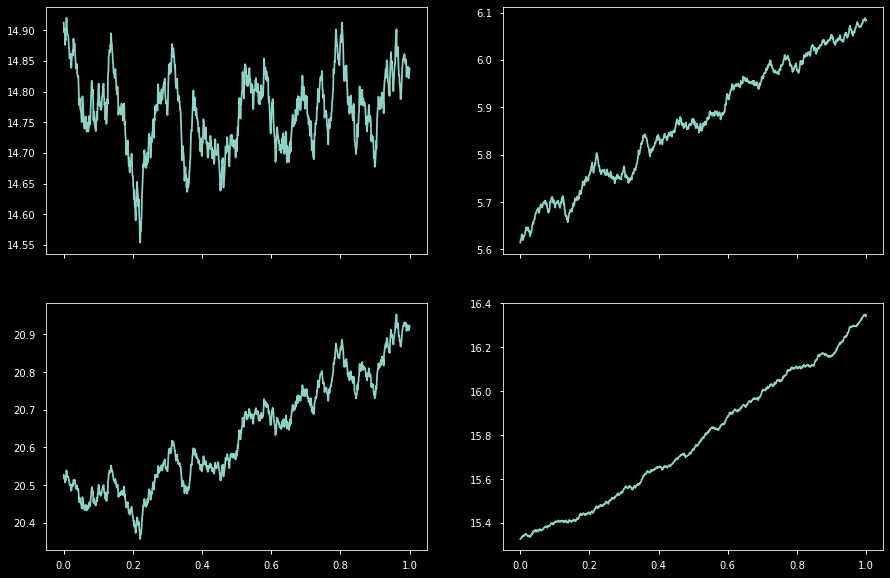

In [113]:
test_path = test_sol.p[0].T
t = np.linspace(*tspan, len(test_path.T))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10), sharex=True)

axs[0,0].plot(t, test_path[0]);
axs[0,1].plot(t, test_path[1]);

axs[1,0].plot(t, test_path[0]+test_path[1]);
axs[1,1].plot(t, G(*test_path)[0]);

### Short trajectories

In [22]:
ens0 = ends

In [23]:
ens0.shape

(20, 2)

In [24]:
Fou_fibers = em.solve(sde_Fou, ends, (0, 1), dt)

In [25]:
Fou_fibers.p.shape

(20, 1001, 2)

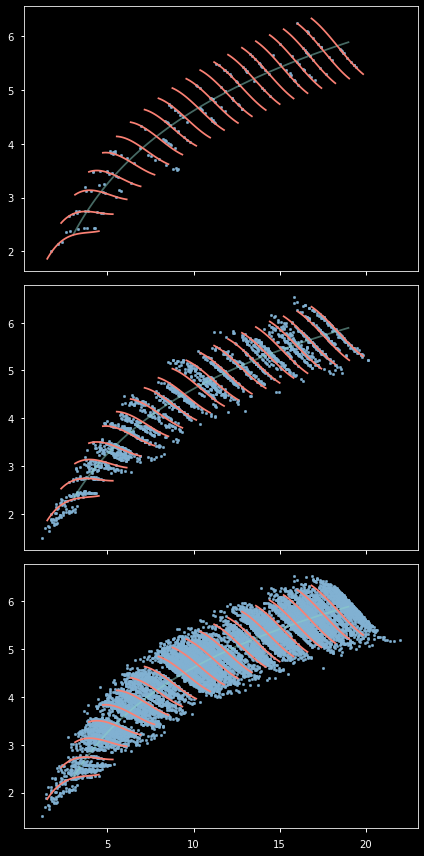

In [26]:
fig, axs = plt.subplots(nrows=3, figsize=(6,12), sharex=True)

for n, ax in enumerate(axs):
    
    ax.plot(*spine, alpha=.5)
    for path, fib in zip(Fou_fibers.p, fibers):
        ax.plot(*fib, color='C3')
        stop = int(len(path)/(10**len(axs)))*10**(n+1)
        ax.scatter(*path[:stop].T, c='C4', s=7)

fig.tight_layout()
plt.show()

In [27]:
nrep = 500
ens0 = np.repeat(ends, nrep, axis=0)

In [28]:
ens0_rep = np.repeat(ends[:,np.newaxis,:], nrep, axis=1)

In [29]:
ens0_rep.shape

(20, 500, 2)

In [30]:
Fou_bursts = em.burst(sde_Fou, ens0, (0, 30), dt).reshape(len(ends), nrep, 2)

In [31]:
Fou_bursts.shape

(20, 500, 2)

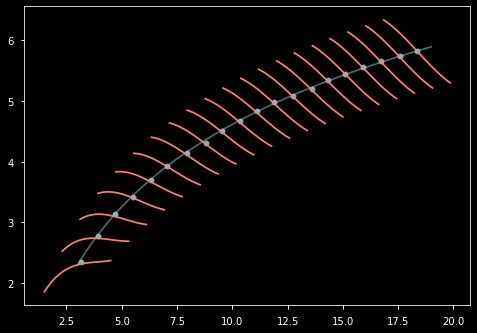

In [32]:
plt.plot(*spine, alpha=.5)
for burst, fib in zip(Fou_bursts, fibers):
    plt.plot(*fib, color='C3')
    mean = np.nanmean(burst, axis=0)
    plt.scatter(*mean.T, c='C4', s=30)

plt.show()

In [33]:
nrep = 250
ens0 = np.repeat(Fdata, nrep, axis=0)

In [34]:
Fou_bursts = em.burst(sde_Fou, ens0, (0, 10), dt).reshape(len(Fdata), nrep, 2)
Fou_bursts.shape

(5001, 250, 2)

In [35]:
means = np.nanmean(Fou_bursts, axis=1)
means.shape

(5001, 2)

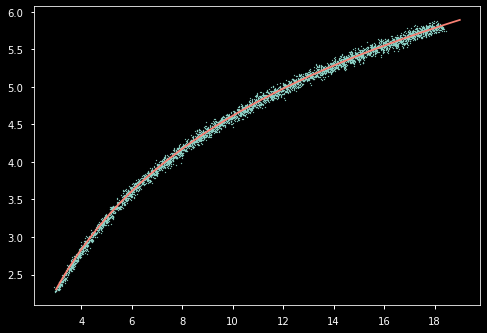

In [36]:
plt.plot(*spine, c='C3')
plt.scatter(*means.T, s=1)
plt.show()

In [37]:
nsam = 1e4
ens = np.vstack([fib.T[::4] for fib in fibers])
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(Fdata, sde_Fou)

In [38]:
ens.shape

(260, 2)

In [39]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*...) is equiv to transposing :)

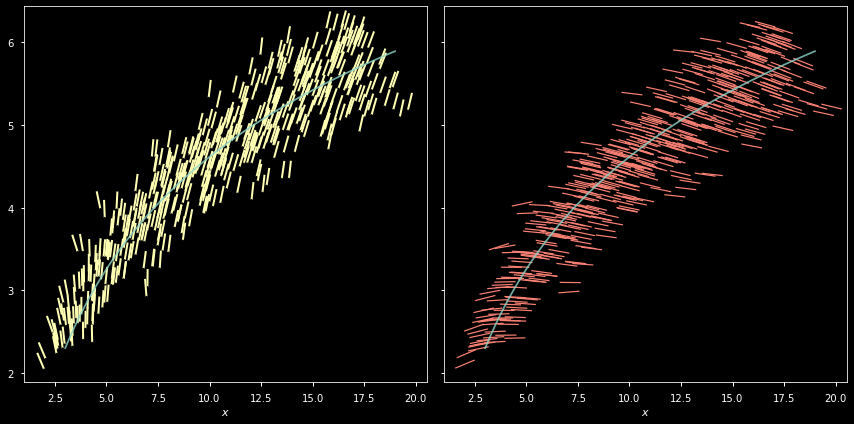

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=True)

step = 10
X, Y = Fdata[::step].T
XS, YS = zip(*[e_vec[:,0] for e_vec in e_vecs[::step]])
XF, YF = zip(*[e_vec[:,1] for e_vec in e_vecs[::step]])

axs[0].quiver(X, Y, XS, YS, pivot="middle", width=0.005, headwidth=0, scale=15, color='C1')
axs[1].quiver(X, Y, XF, YF, pivot="middle", width=0.003, headwidth=0, scale=15, color='C3')
# for d, e_vec in zip(data[:1000], e_vecs):
# #     print(d)
#     plt.quiver(*d, *e_vec[:,0], pivot="middle", width=0.003, scale=50)

for ax in axs:
    ax.plot(*spine, alpha=.8)
#     ax.set_xlim([-1, 1])
#     ax.set_xticks([-1, 1])
#     ax.set_ylim([-1, 1])
#     ax.set_yticks([-1, 1])
#     ax.set_aspect("equal")
    ax.set_xlabel("$x$")
#     ax.set_ylabel("$y$", rotation=0)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [41]:
nsam = 1e4
ens = np.vstack([fib.T[::5] for fib in fibers])
print(f"{ens.shape = }")
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(ens, sde_Fou)

# nsam = 10**5
# ln_covs = dmaps.ln_covs(ens, sde_Fou, em, nsam, dt)

ens.shape = (200, 2)


In [42]:
ln_prcs = [np.linalg.pinv(cov) for cov in ln_covs]

In [43]:
lnc_evals, lnc_evecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*...) is equiv to transposing :)

In [44]:
lnp_evals, lnp_evecs = zip(*[np.linalg.eigh(pre) for pre in ln_prcs])

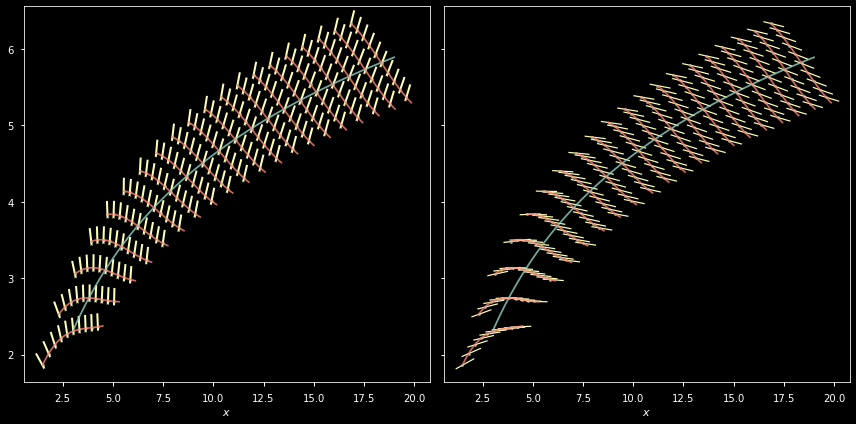

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=True)

step = 10
X, Y = ens.T

XS, YS = np.array([e_vec[:,0] for e_vec in lnc_evecs]).T
XF, YF = np.array([e_vec[:,1] for e_vec in lnc_evecs]).T
# XS, YS = zip(*[e_vec[:,1] for e_vec in lnp_evecs])
# XF, YF = zip(*[e_vec[:,0] for e_vec in lnp_evecs])

# axs[0].quiver(X, Y, XS, YS, pivot="middle", width=0.005, headwidth=0, scale=15, color='C1')
# axs[1].quiver(X, Y, XF, YF, pivot="middle", width=0.003, headwidth=0, scale=15, color='C3')
# for d, e_vec in zip(data[:1000], e_vecs):
# #     print(d)
#     plt.quiver(*d, *e_vec[:,0], pivot="middle", width=0.003, scale=50)

for ax in axs:
    ax.plot(*spine, alpha=.8)
    for fib in fibers:
        ax.plot(*fib, c='C3', alpha=.8)
    ax.scatter(*ens.T, s=5)
#     ax.set_xlim([-1, 1])
#     ax.set_xticks([-1, 1])
#     ax.set_ylim([-1, 1])
#     ax.set_yticks([-1, 1])
#     ax.set_aspect("equal")
    ax.set_xlabel("$x$")
#     ax.set_ylabel("$y$", rotation=0)

axs[0].quiver(X, Y, XS, YS, pivot="middle", width=0.005, headwidth=0, scale=15, color='C1')
axs[1].quiver(X, Y, XF, YF, pivot="middle", width=0.003, headwidth=0, scale=15, color='C1')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [46]:
npts = 10
u = np.linspace(6, 10, npts)
slow = np.array(F(u, u)).T

u0 = np.mean(u)
v = np.linspace(u0-2, u0+2, npts+1)
fast = np.array(F(u0, v)).T

In [47]:
ens = np.vstack([slow, fast])

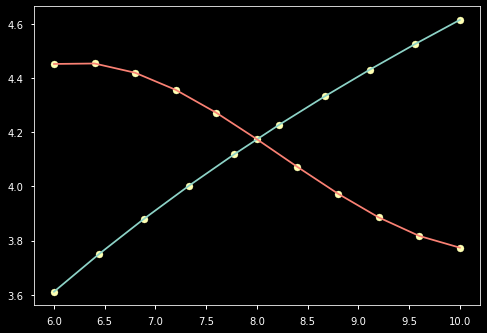

In [48]:
plt.plot(*slow.T)
plt.plot(*fast.T, c='C3')
plt.scatter(*ens.T, c='C1');

In [49]:
ln_covs = dmaps.lnc_ito(ens, sde_Fou)
ln_prcs = [np.linalg.pinv(cov) for cov in ln_covs]
id_covs = (np.eye(2)[..., None] * np.ones(len(ens))).T

In [50]:
eps = 6

In [51]:
aff_id = dmaps.data_affinity(ens, id_covs, eps)

Computing affinity matrix for epsilon = 6 


In [52]:
aff_ln = dmaps.data_affinity(ens, ln_covs, eps)

Computing affinity matrix for epsilon = 6 


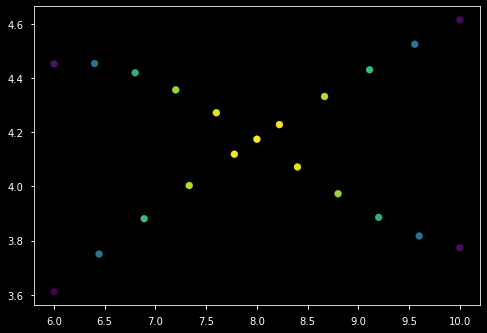

In [53]:
plt.scatter(*ens.T, c=aff_id[-6]);

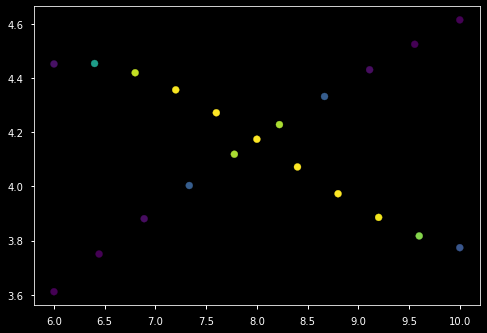

In [54]:
plt.scatter(*ens.T, c=aff_ln[-6]);